# Logistic Regression and Model Comparison with Bambi and Arviz

## Adults dataset

The [adults dataset](http://archive.ics.uci.edu/ml/datasets/Adult) is comprised of census data from 1994 in United States.  
The goal is to use demographic variables to predict whether an individual makes more than $50,000 per year. 

The following a desciption of the variables in the dataset.

* **age**: Individual's age
* **workclass**: Labor class.
* **fnlwgt**: It is no specified, but I guess it is a final sampling weight.
* **education**: Education level as a categorical variable.
* **educational_num**: Education level as numerical variable. It does not reflect years of education.
* **marital_status**: Marital status.
* **occupation**: Occupation.
* **relationship**: Relationship with the head of household.
* **race**: Individual's race.
* **sex**: Individual's sex.
* **capital_gain**: Capital gain during period of time not specified.
* **capital_loss**: Capital loss during period of time not specified.
* **hs_week**: Hours of work per week.
* **native_country**: Country of birth.
* **income**: Income as a binary variable (either below or above 50K per year).

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import seaborn as sns

from pandas.api.types import CategoricalDtype

In [2]:
az.style.use("arviz-darkgrid")

BLUE = "#2980b9"
RED = "#e74c3c"
GREEN = "#27ae60"
YELLOW = "#e1b12c"

In [3]:
print(az.__version__)
print(bmb.__version__)

0.10.0
0.2.0


In [4]:
data = pd.read_table("data/adult.data", header=None, sep = ",", skipinitialspace=True, 
                     names=['age', 'workclass', 'fnlwgt', 'education', 'education_num',
                            'marital_status', 'occupation', 'relationship', 'race', 'sex',
                            'captial_gain', 'capital_loss', 'hs_week', 'native_country',
                            'income'])

In [5]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  captial_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hs_week         32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,captial_gain,capital_loss,hs_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Categorical variables are presented as from type `object`. In this step we convert them to `category`.

In [6]:
categorical_cols = data.columns[data.dtypes == object].tolist()
for col in categorical_cols:
    data[col] = data[col].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             32561 non-null  int64   
 1   workclass       32561 non-null  category
 2   fnlwgt          32561 non-null  int64   
 3   education       32561 non-null  category
 4   education_num   32561 non-null  int64   
 5   marital_status  32561 non-null  category
 6   occupation      32561 non-null  category
 7   relationship    32561 non-null  category
 8   race            32561 non-null  category
 9   sex             32561 non-null  category
 10  captial_gain    32561 non-null  int64   
 11  capital_loss    32561 non-null  int64   
 12  hs_week         32561 non-null  int64   
 13  native_country  32561 non-null  category
 14  income          32561 non-null  category
dtypes: category(9), int64(6)
memory usage: 1.8 MB


We are going to continue the analysis with the following variables: **age**, **sex**, **race**, **hs_week**, and **income**. This subset is comprised of both categorical and numerical variables which allows us to visualize how to incorporate both types in a logistic regression model while helping to keep the analysis simpler.

In [7]:
data = data[["age", "sex", "race", "hs_week", "income"]]

Instead of going straight to fitting models, we're going to do a some exploratory analysis of the variables in the dataset. First we have some plots, and then some conclusions about the information in the plots.

In [8]:
# This is just a utilitary function to truncate labels and avoid overlapping
def truncate_labels(ticklabels, width=8):
    def truncate(label, width):
        if len(label) > width - 3:
            return label[0:(width - 4)] + '...'
        else:
            return label
    labels = [x.get_text() for x in ticklabels]
    labels = [truncate(lbl, width) for lbl in labels]
    
    return labels

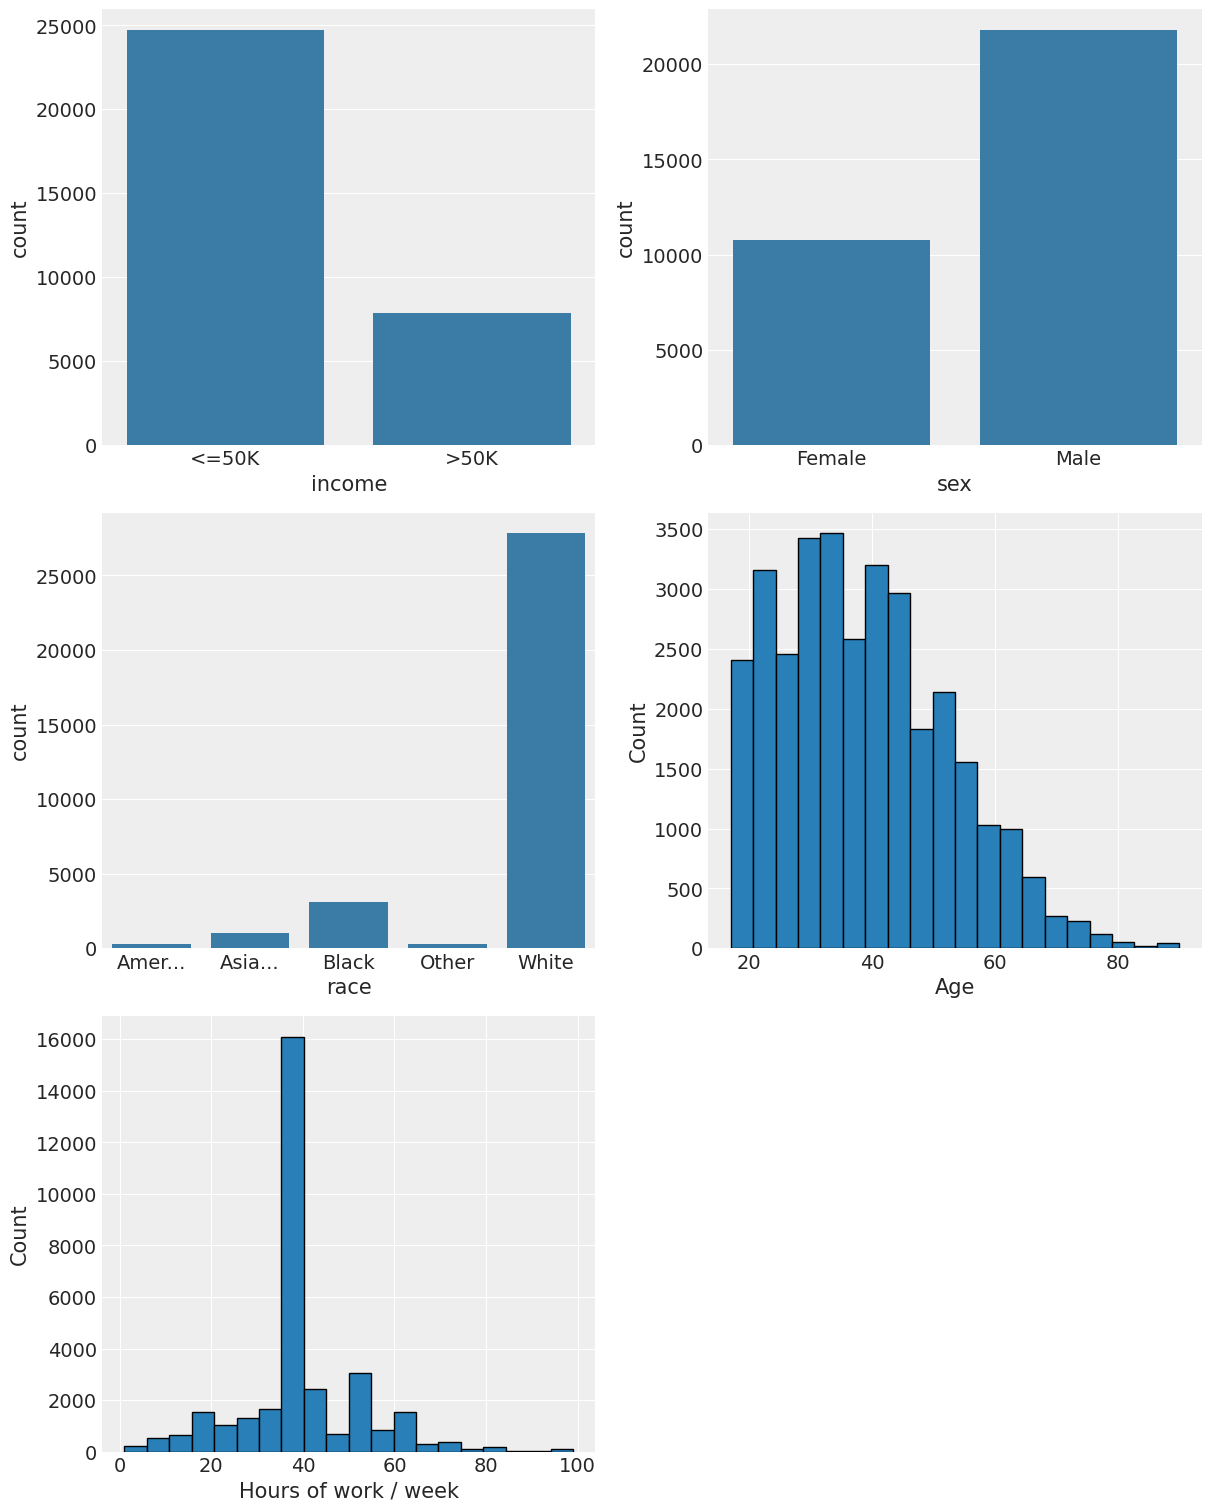

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
sns.countplot(x="income", color=BLUE, data=data, ax=axes[0, 0])
sns.countplot(x="sex", color=BLUE, data=data, ax=axes[0, 1]);
sns.countplot(x="race", color=BLUE, data=data, ax=axes[1, 0]);
axes[1, 0].set_xticklabels(truncate_labels(axes[1, 0].get_xticklabels()))
axes[1, 1].hist(data["age"], bins=20, edgecolor="black", color=BLUE);
axes[1, 1].set_xlabel("Age")
axes[1, 1].set_ylabel("Count")
axes[2, 0].hist(data["hs_week"], bins=20, edgecolor="black", color=BLUE);
axes[2, 0].set_xlabel("Hours of work / week")
axes[2, 0].set_ylabel("Count")
axes[2, 1].axis('off');

**Highlights**

* Approximately 25% of the people make more than 50K a year.
* Two thirds of the subjects are males.
* The three most frequent education categories are high school graduate, some college and bachelors. **[udpate]**
* The great majority of the subjects are white, only a minority are black and the other categories are very infrequent.
* The distribution of age is skewed to the right, as one might expect.
* The distribution of hours of work per week looks weird at first sight. But what is a typical workload per week? You got it, 40 hours :).

We only keep the races black and white to simplify the analysis. The other categories don't appear very often in our data. 

Now, we see the distribution of income for the different levels of our explanatory variables. Numerical variables are binned to make the analysis possible.

In [10]:
data = data[data["race"].isin(["Black", "White"])]
data["race"] = data["race"].cat.remove_unused_categories()
age_bins = [17, 25, 35, 45, 65, 90]
data["age_binned"] = pd.cut(data["age"], age_bins)
hours_bins = [0, 20, 40, 60, 100]
data["hs_week_binned"] = pd.cut(data["hs_week"], hours_bins) 

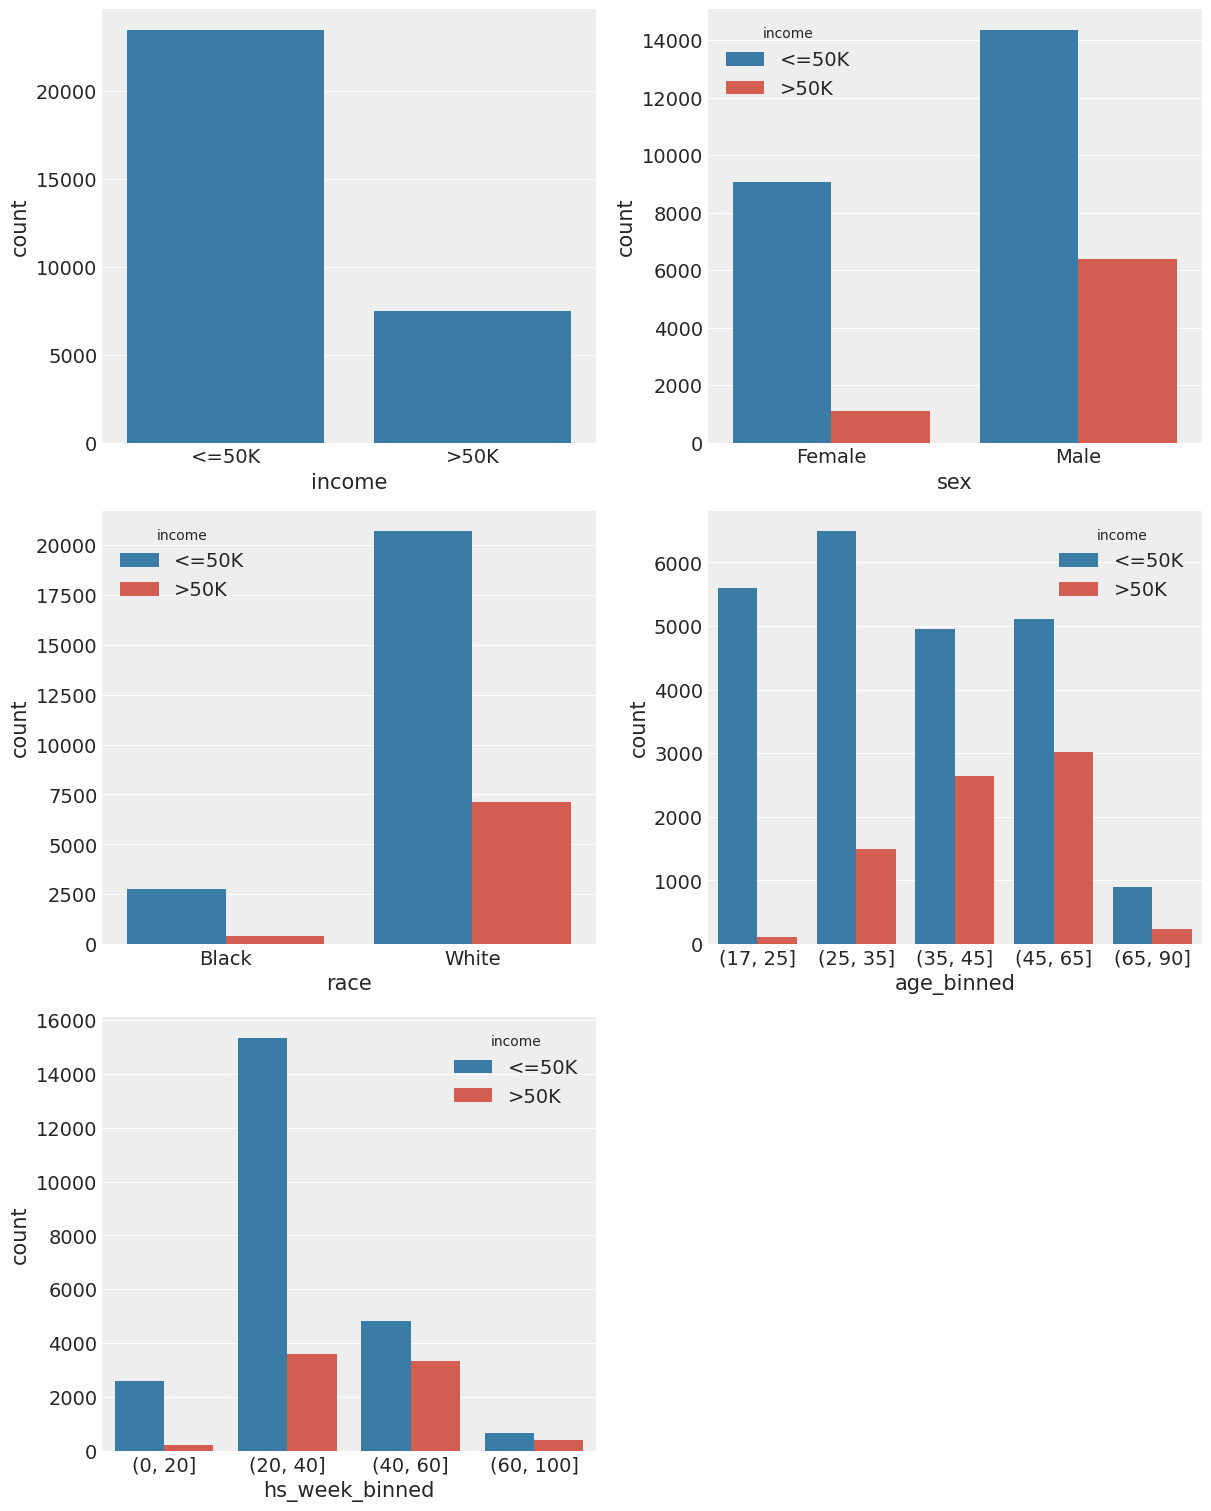

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
sns.countplot(x="income", color=BLUE, data=data, ax=axes[0, 0])
sns.countplot(x="sex", hue="income", palette=[BLUE, RED], data=data, ax=axes[0, 1]);
sns.countplot(x="race", hue="income", palette=[BLUE, RED], data=data, ax=axes[1, 0])
sns.countplot(x="age_binned", hue="income", palette=[BLUE, RED], data=data, ax=axes[1, 1])
sns.countplot(x="hs_week_binned", hue="income", palette=[BLUE, RED], data=data, ax=axes[2, 0])
axes[2, 1].axis('off');

Some data preparation before fitting our model... **complete this paragraph**

In [12]:
age_mean = np.mean(data["age"])
age_std = np.std(data["age"])
hs_mean = np.mean(data["hs_week"])
hs_std = np.std(data["hs_week"])

data["age"] = (data["age"] - age_mean) / age_std
data["age2"] = data["age"] ** 2
data["age3"] = data["age"] ** 3
data["hs_week"] = (data["hs_week"] - hs_mean) / hs_std
data["hs_week2"] = data["hs_week"] ** 2
data["hs_week3"] = data["hs_week"] ** 3

data = data.drop(columns=['age_binned', 'hs_week_binned'])

In [13]:
data.head()

,age,sex,race,hs_week,income,age2,age3,hs_week2,hs_week3
0,0.024207,Male,White,-0.037250,<=50K,0.000586,0.000014,0.001388,-0.000052
1,0.827984,Male,White,-2.222326,<=50K,0.685557,0.567630,4.938734,-10.975479
2,-0.048863,Male,White,-0.037250,<=50K,0.002388,-0.000117,0.001388,-0.000052
3,1.047195,Male,Black,-0.037250,<=50K,1.096618,1.148374,0.001388,-0.000052
4,-0.779569,Female,Black,-0.037250,<=50K,0.607728,-0.473766,0.001388,-0.000052


## The model

We will use a logistic regression model to estimate the probability of making more than $50K as a function of age, hours of work per week, sex, race and education level.

If we have a binary response variable $Y$ and a set of predictors or explanatory variables $X_1, X_2, \cdots, X_p$ the logistic regression model can be defined as follows:

$$\log{\left(\frac{\pi}{1 - \pi}\right)} = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p$$

where $\pi = P(Y = 1)$ (a.k.a. probability of success) and $\beta_0, \beta_1, \cdots \beta_p$ are unknown parameters. The term on the left side is the logarithm of the odds ratio or simply known as the log-odds. With little effort, the expression can be re-arranged to express our probability of interest, $\pi$, as a function of the betas and the predictors.

$$
\pi = \frac{e^{\beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p}}{1 + e^{\beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p}}
    = \frac{1}{1 + e^{\beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p}}
$$

We need to specify a prior and a likelihood in order to draw samples from the posterior distribution. We could use sociological knowledge about the effects of age and education on income, but instead, let’s use the default prior specification in Bambi.

The likelihood is the product of $n$ Bernoulli trials, $\prod_{i=1}^{n}{p_i^y(1-p_i)^{1-y_i}}$ where $p_i = P(Y=1)$.  

In our case, we have 

$$Y = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person makes more than 50K per year} \\
        0 & \textrm{if the person makes less than 50K per year} 
    \end{array}
\right.
$$

$$\pi = P(Y=1)$$

But this is a Bambi example, right? Let's see how Bambi can helps us to build a logistic regression model.

## Model 1:

$$
\log{\left(\frac{\pi}{1 - \pi}\right)} = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4   
$$

Where:

$
X_1 = \textrm{Age / 10} \\
X_2 = \textrm{Hours of work per week / 10} \\
X_3 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person is male} \\
        0 & \textrm{if the person is female} 
    \end{array}
\right. \\
X_4 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person is white} \\
        0 & \textrm{if the person is black} 
    \end{array}
\right. \\
$ 


In [14]:
model1 = bmb.Model(data)
fitted1 = model1.fit('income[>50K] ~ sex + race + age + hs_week',
                     family='bernoulli', draws=1000)

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/bambi/models.py:259: UserWarning: Modeling the probability that income=='>50K'
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [hs_week, age, race, sex, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 69 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.633,0.062,-2.747,-2.516,0.002,0.002,821.0,818.0,814.0,1002.0,1.01
sex,1.018,0.037,0.944,1.082,0.001,0.001,1843.0,1843.0,1842.0,1260.0,1.00
race,0.628,0.057,0.522,0.731,0.002,0.001,966.0,959.0,956.0,1072.0,1.00
age,0.578,0.015,0.549,0.608,0.000,0.000,1993.0,1993.0,1994.0,1100.0,1.00
hs_week,0.504,0.015,0.475,0.532,0.000,0.000,1617.0,1617.0,1636.0,1194.0,1.00


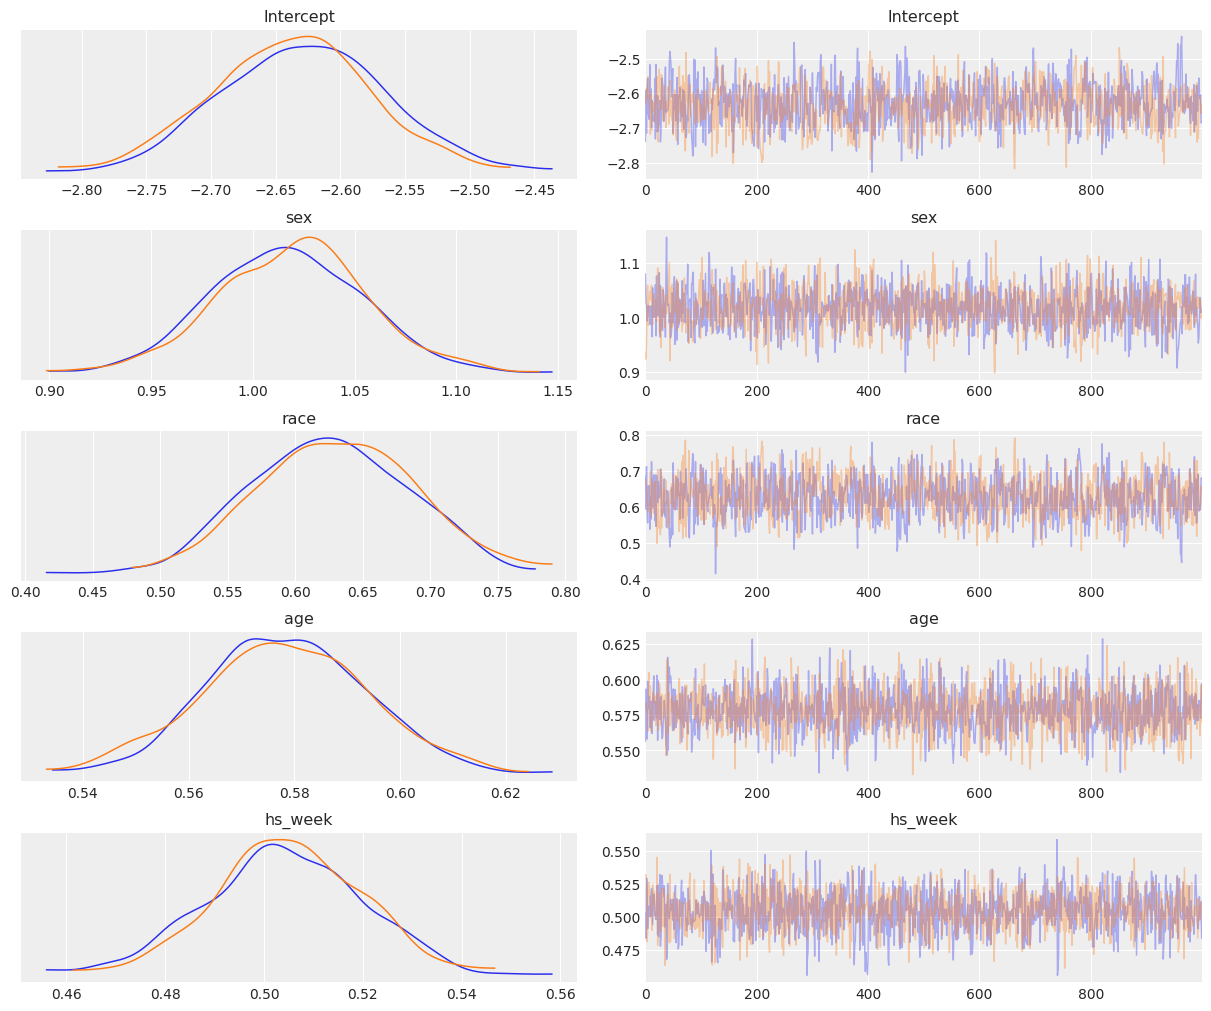

In [15]:
az.plot_trace(fitted1);
az.summary(fitted1)

## Model 2

$$
\log{\left(\frac{\pi}{1 - \pi}\right)} = \beta_0 + \beta_1 X_1 + \beta_2 X_1^2 + \beta_3 X_2 + \beta_4 X_2^2
                                         + \beta_5 X_3 + \beta_6 X_4
$$

Where: 

$
X_1 = \textrm{Age / 10} \\
X_2 = \textrm{Hours of work per week / 10} \\
X_3 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person is male} \\
        0 & \textrm{if the person is female} 
    \end{array}
\right. \\
X_4 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person is white} \\
        0 & \textrm{if the person is black} 
    \end{array}
\right. 
$

In [16]:
model2 = bmb.Model(data)
fitted2 = model2.fit('income[>50K] ~ sex + race + age + age2 + hs_week + hs_week2',
                     family='bernoulli', draws=1000)

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/bambi/models.py:259: UserWarning: Modeling the probability that income=='>50K'
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [hs_week2, hs_week, age2, age, race, sex, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 77 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.284,0.066,-2.404,-2.165,0.002,0.001,1049.0,1048.0,1049.0,1151.0,1.0
sex,1.006,0.038,0.937,1.079,0.001,0.001,1471.0,1459.0,1493.0,1230.0,1.0
race,0.704,0.062,0.597,0.824,0.002,0.001,1226.0,1217.0,1220.0,1099.0,1.0
age,1.070,0.023,1.027,1.114,0.001,0.000,1601.0,1593.0,1605.0,1118.0,1.0
age2,-0.538,0.017,-0.571,-0.508,0.000,0.000,1368.0,1360.0,1369.0,1438.0,1.0
hs_week,0.500,0.023,0.459,0.542,0.001,0.000,1296.0,1296.0,1290.0,1240.0,1.0
hs_week2,-0.088,0.008,-0.104,-0.073,0.000,0.000,1602.0,1595.0,1600.0,1470.0,1.0


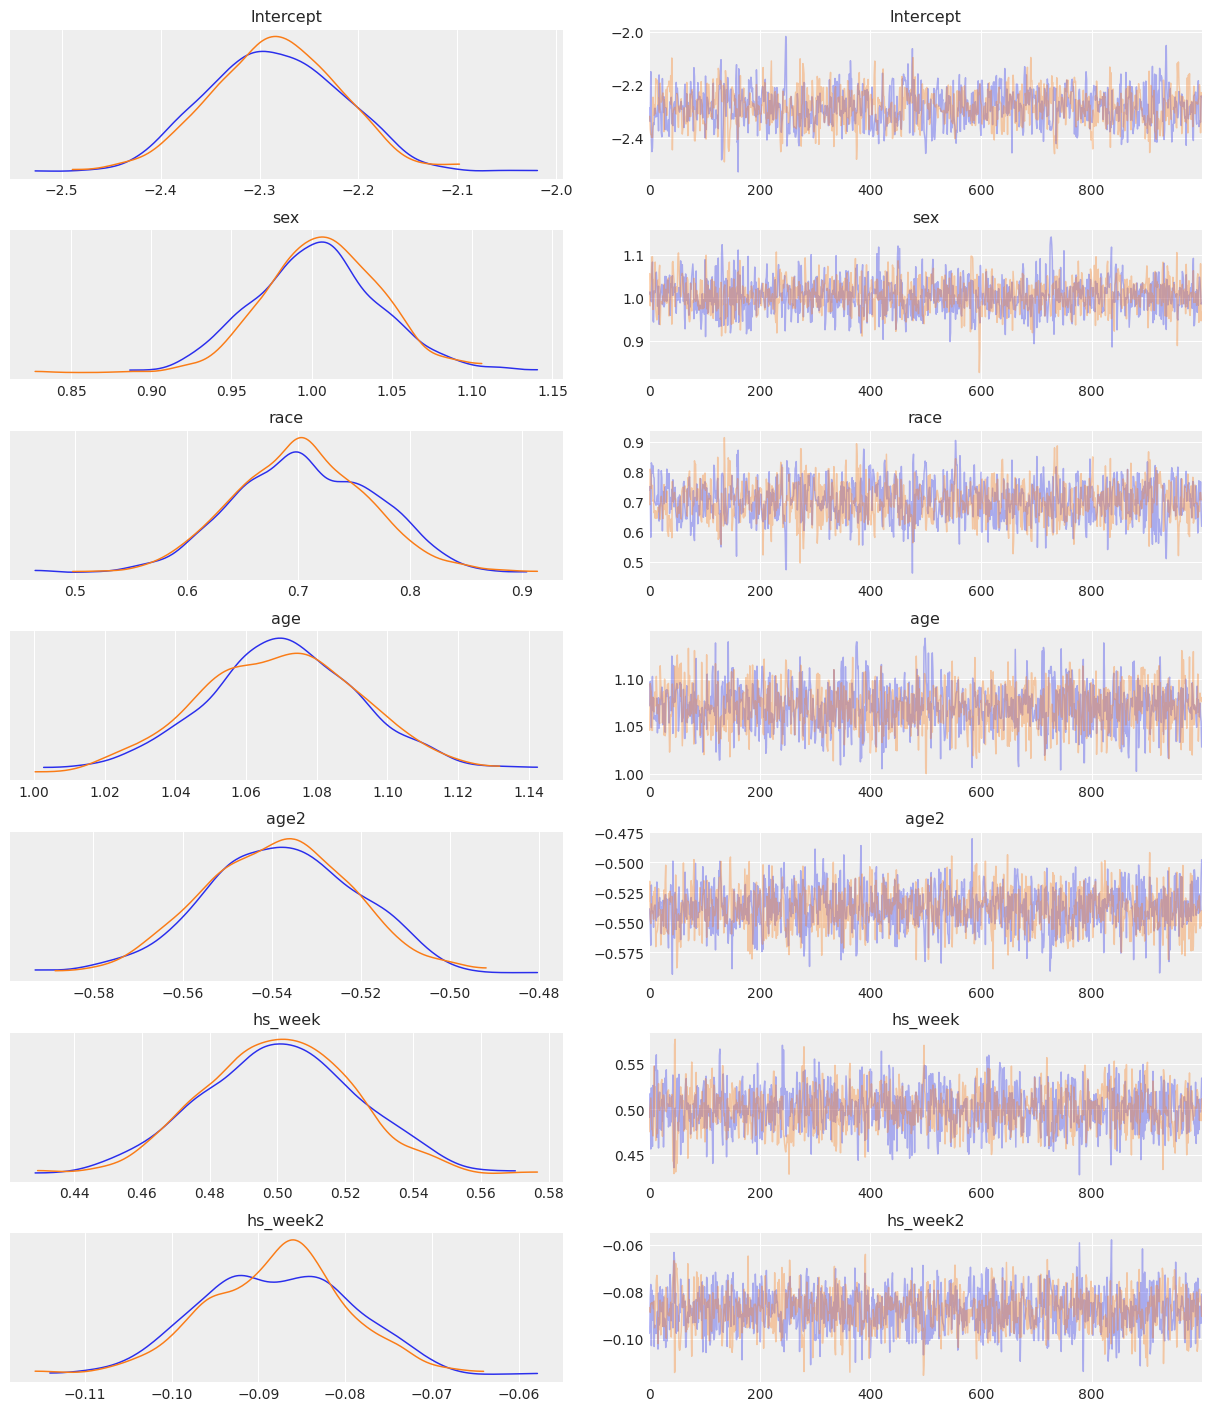

In [17]:
az.plot_trace(fitted2);
az.summary(fitted2)

## Model 3

$$
\log{\left(\frac{\pi}{1 - \pi}\right)} = \beta_0 + \beta_1 X_1 + \beta_2 X_1^2 + \beta_3 X_1^3 + \beta_4 X_2 
                                         + \beta_5 X_2^2 + \beta_6 X_2^3 + \beta_7 X_3 + \beta_8 X_4
$$

Where: 

$
X_1 = \textrm{Age / 10} \\
X_2 = \textrm{Hours of work per week / 10} \\
X_3 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person is male} \\
        0 & \textrm{if the person is female} 
    \end{array}
\right. \\
X_4 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person is white} \\
        0 & \textrm{if the person is black} 
    \end{array}
\right. 
$

In [18]:
model3 = bmb.Model(data)
fitted3 = model3.fit('income[>50K] ~ age + age2 + age3 + hs_week + hs_week2 + hs_week3 + sex + race',
                     family='bernoulli', draws=1000)

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/bambi/models.py:259: UserWarning: Modeling the probability that income=='>50K'
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [hs_week3, hs_week2, hs_week, age3, age2, age, race, sex, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 102 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.148,0.064,-2.271,-2.031,0.002,0.001,1472.0,1470.0,1467.0,1280.0,1.0
sex,0.986,0.036,0.913,1.049,0.001,0.001,2014.0,2002.0,2027.0,1396.0,1.0
race,0.681,0.061,0.565,0.792,0.002,0.001,1564.0,1556.0,1560.0,1418.0,1.0
age,0.964,0.024,0.917,1.005,0.000,0.000,2945.0,2945.0,2933.0,1481.0,1.0
age2,-0.894,0.030,-0.955,-0.842,0.001,0.001,1329.0,1328.0,1351.0,1380.0,1.0
age3,0.175,0.011,0.154,0.195,0.000,0.000,1346.0,1346.0,1345.0,1262.0,1.0
hs_week,0.613,0.024,0.568,0.659,0.001,0.000,1800.0,1797.0,1803.0,1554.0,1.0
hs_week2,-0.010,0.011,-0.030,0.009,0.000,0.000,1922.0,1439.0,1924.0,1301.0,1.0
hs_week3,-0.035,0.004,-0.042,-0.029,0.000,0.000,1549.0,1546.0,1548.0,1507.0,1.0


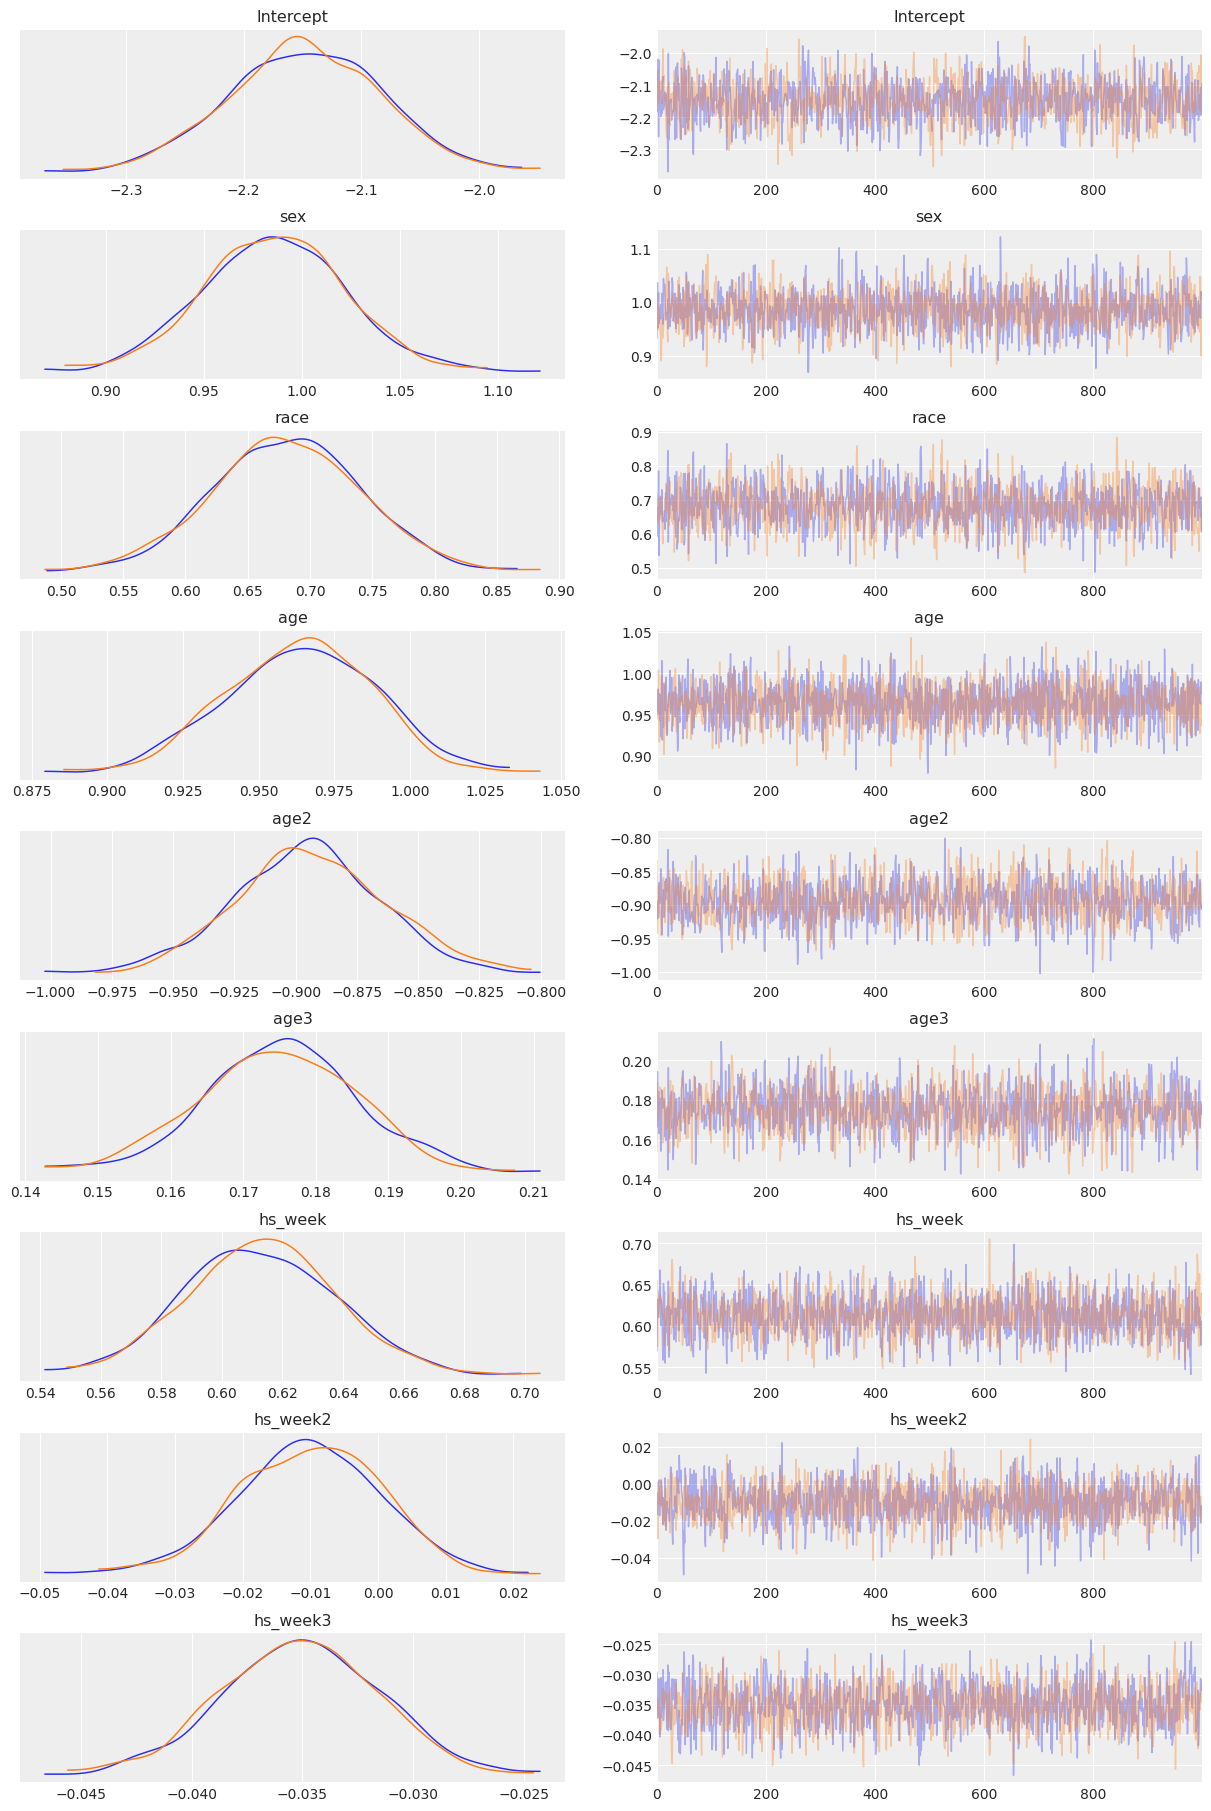

In [19]:
az.plot_trace(fitted3);
az.summary(fitted3)

## Model comparison

In [20]:
models_dict = {
    "model1": fitted1,
    "model2": fitted2,
    "model3": fitted3
}
df_compare = az.compare(models_dict)
df_compare

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model3,0,-13987.1,9.59564,0,NaN,90.5837,0,False,log
model2,1,-14154.8,7.83274,167.714,NaN,91.6198,19.9319,False,log
model1,2,-14915.9,4.91433,928.824,0,89.1521,38.9251,False,log


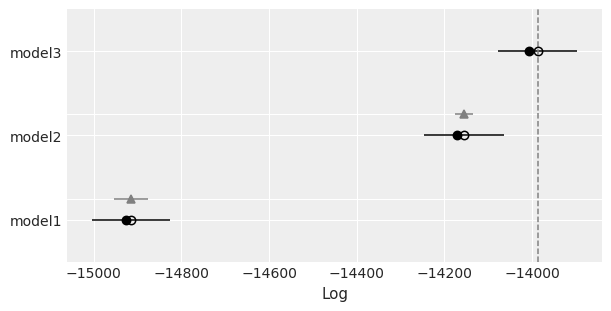

In [21]:
az.plot_compare(df_compare);

There is a difference in the point estimations between the model with cubic terms (model 3) and the model with quadratic terms (model 2) but there is some overlap between their interval estimations. This time, we are going to select model 2 and do some extra little work with it because from previous experience with this dataset we know there is no substantial difference between them, and model 2 is simpler. If you want, you could also try to add other predictors, such as education level and see how it impacts in the model comparison :). 

## Probability estimation

In this section we plot age vs the probability of making more than 50K a year given different profiles.

In [22]:
posterior = fitted2.posterior
def invlogit(x):
    return 1 / (1 + np.exp(-x))

We set hours of work per week at 40 hours and assign a grid from 18 to 75 age. They're standardized because they
were standardized when we fitted the model.

In [23]:
HS_WEEK = (40 - hs_mean) / hs_std
AGE = (np.linspace(18, 75) - age_mean) / age_std
AGE = AGE[:, None]

Now we compute the intercepts for the four combinations between sex and race.

In [24]:
int_fem_black = posterior['Intercept'].values.reshape(-1, )
int_mal_black = int_fem_black + posterior['sex'].values.reshape(-1, )
int_fem_white = int_fem_black + posterior['race'].values.reshape(-1, )
int_mal_white = int_mal_black + posterior['race'].values.reshape(-1, )

Add the effect of hours of work per week.

In [25]:
hs_contr = HS_WEEK * posterior['hs_week'].values.reshape(-1, ) 
hs_contr += HS_WEEK ** 2 * posterior['hs_week2'].values.reshape(-1, )

And the linear predictor for all the ages in the grid.

In [26]:
age_contr = np.dot(AGE, posterior['age'].values.reshape(-1, )[:, None].T)
age_contr += np.dot(AGE ** 2, posterior['age2'].values.reshape(-1, )[:, None].T)

Then we just store all the linear predictors in a list called `eta`.

In [27]:
eta_base = hs_contr + age_contr
eta_fem_black = int_fem_black + eta_base
eta_mal_black = int_mal_black + eta_base
eta_fem_white = int_fem_white + eta_base
eta_mal_white = int_mal_white + eta_base

etas = [eta_fem_black, eta_mal_black, eta_fem_white, eta_mal_white]
age = AGE * age_std + age_mean

And finally, the plot :)

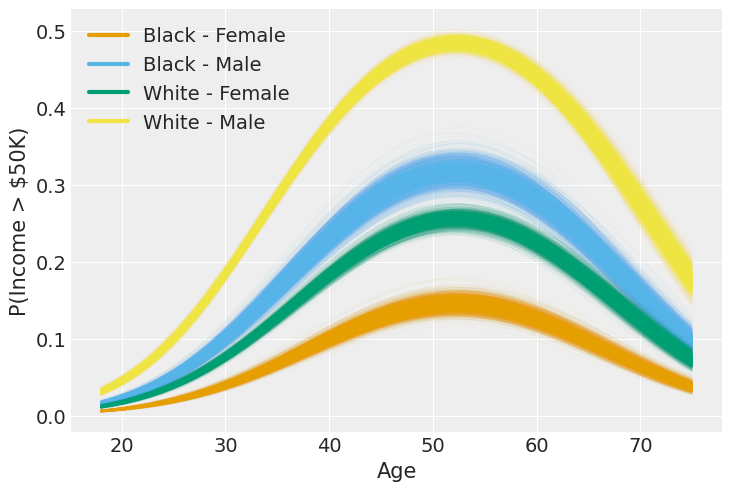

In [28]:
colors = ["#E69F00", "#56B4E9", "#009E73" ,"#F0E442"]
labels = ["Black - Female", "Black - Male", "White - Female", "White - Male"]
handles = []
for idx in range(len(etas)):
    plt.plot(age, invlogit(etas[idx]), color = colors[idx], lw = 0.5, alpha = 0.05)
    handles.append(mlines.Line2D([], [], color=colors[idx], label=labels[idx], lw=3))

plt.xlabel("Age")
plt.ylabel("P(Income > $50K)")
plt.legend(handles=handles, loc="upper left");

Each curve shows how the probability of earning more than 50K changes with age for a given profile. In all the cases, we see the probability of making more than $50K increases with age until approximately age 52, when the probability begins to drop off. Notice that we don't see a single curve for each group. This is because we are actually plotting 2000 different curves for each combination of race and sex. Each curve is a draw from our posterior distribution. Because the curves are somewhat translucent, we can interpret dark, narrow portions of a curve as places where we have low uncertainty and light, spread out portions of the curve as places where we have somewhat higher uncertainty about our coefficient values.